### Import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import joblib

### Data preprocessing

In [36]:
data = pd.read_excel("../data/raw/Online Retail.xlsx")

In [37]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [38]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [39]:
rows, cols = data.shape
print("number of rows:",rows)
print("number of columns:",cols)

number of rows: 541909
number of columns: 8


In [40]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [41]:
missing = data.isnull().sum()
missing

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [42]:
# Drop Description, CustomerID, InvoiceNo and StockCode columns
data.drop(['Description', 'InvoiceNo', 'StockCode', 'InvoiceDate', 'CustomerID'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Quantity   541909 non-null  int64  
 1   UnitPrice  541909 non-null  float64
 2   Country    541909 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 12.4+ MB


In [43]:
# Drop rows with negative Quantity
data = data[data['Quantity'] > 0]

In [44]:
# Drop rows with negative UnitPrice
data = data[data['UnitPrice'] > 0]

In [45]:
# Remove outliers in Quantity
Q1 = data['Quantity'].quantile(0.25)
Q3 = data['Quantity'].quantile(0.75)
IQR = Q3 - Q1 
data = data[(data['Quantity'] >= (Q1 - 1.5 * IQR)) & (data['Quantity'] <= (Q3 + 1.5 * IQR))] 

In [46]:
# Remove outliers in UnitPrice
Q1 = data['UnitPrice'].quantile(0.25)
Q3 = data['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['UnitPrice'] >= (Q1 - 1.5 * IQR)) & (data['UnitPrice'] <= (Q3 + 1.5 * IQR))]

In [47]:
data.describe()

,Quantity,UnitPrice
count,442666.000000,442666.000000
mean,4.904070,2.784289
std,4.495069,2.036175
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,8.000000,3.750000
max,23.000000,8.500000


In [48]:
# Create new TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [60]:
data.to_csv('../data/processed/output_with_index.csv', index=True, header=True)

### Visualize

<Axes: ylabel='Country'>

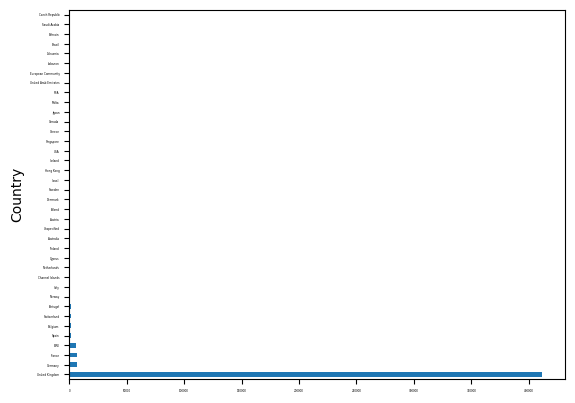

In [49]:
# Frequency of each country
data['Country'].value_counts().plot(kind='barh', fontsize=2)

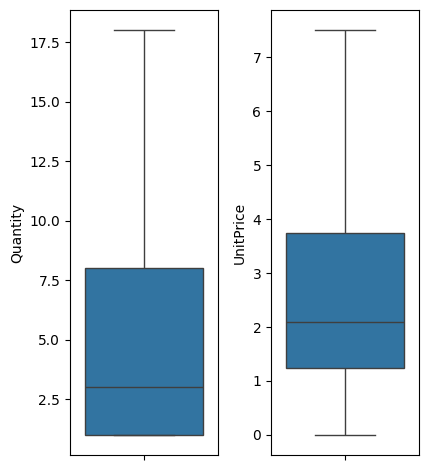

In [52]:
# Boxplot of Quantity and UnitPrice
plt.subplot(1, 3, 1)
sns.boxplot(y='Quantity', data=data, showfliers=False)

plt.subplot(1, 3, 2)
sns.boxplot(y='UnitPrice', data=data, showfliers=False)

plt.tight_layout()

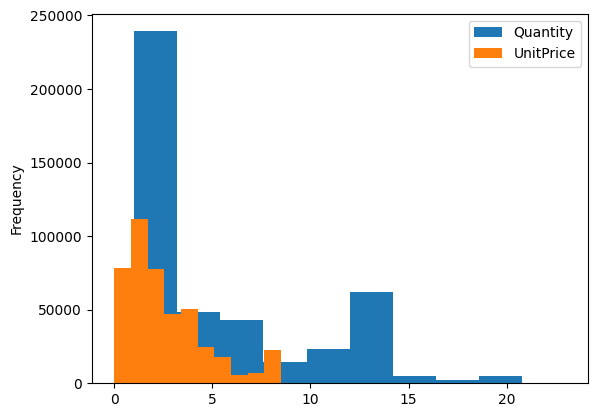

In [53]:
# Histogram of Quantity and UnitPrice
data['Quantity'].plot(kind='hist', bins=10)
data['UnitPrice'].plot(kind='hist', bins=10)

plt.legend(['Quantity', 'UnitPrice'])

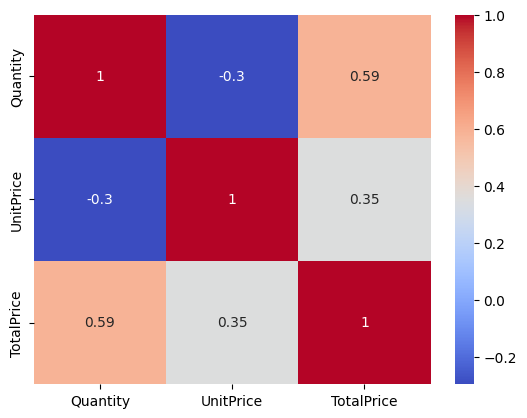

In [54]:
# Correlation matrix
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### Model training

This is an unsupervised problem with no target variable.

In [55]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

In [56]:
# Encode the Country column
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train['Country'] = encoder.fit_transform(train['Country'])
test['Country'] = encoder.transform(test['Country'])

#### Choose optimal K value with Elbow method

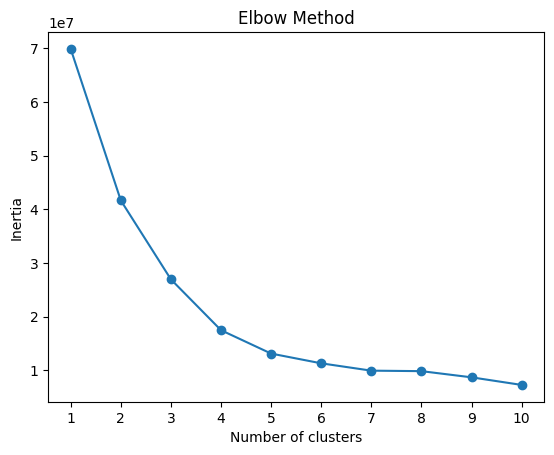

In [57]:
# K-Means Clustering
from sklearn.cluster import KMeans


# Find the best number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(train)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

=> Nums of optimal K is 3.

#### Model training

In [75]:
train

,Quantity,UnitPrice,Country,TotalPrice,Cluster
343625,1,4.13,36,4.13,0
260581,2,4.13,36,8.26,0
428742,3,1.65,36,4.95,0
489901,4,5.95,36,23.80,1
338653,4,2.55,36,10.20,0
...,...,...,...,...,...
319834,2,0.63,36,1.26,0
450584,4,1.25,36,5.00,0
161997,1,0.83,36,0.83,0
180581,10,2.10,36,21.00,1


c:\Users\DELL\anaconda3\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


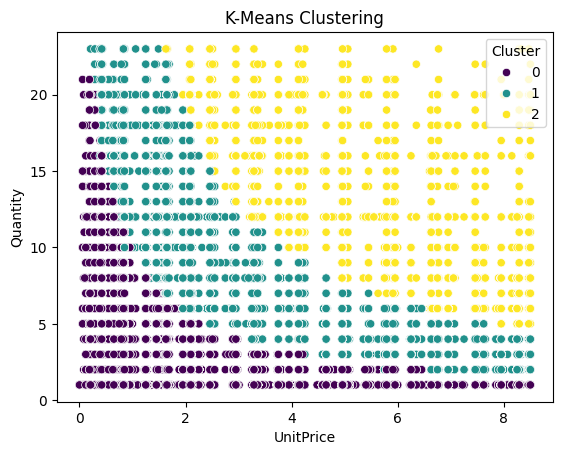

In [59]:
# Fit the model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
train['Cluster'] = kmeans.fit_predict(train)

# Visualize the clusters
sns.scatterplot(x='UnitPrice', y='Quantity', hue='Cluster', data=train, palette='viridis')
plt.title('K-Means Clustering')
plt.show()

In [67]:
joblib.dump(encoder, '../models/label_encoder.joblib')
joblib.dump(kmeans, '../models/kmeans_model.joblib')

['../models/kmeans_model.joblib']

Cluster for new data: 
   Quantity  UnitPrice  Country  TotalPrice  Cluster
0      14.0         28       13       392.0        2
1      25.0         52       13      1300.0        2
2       6.0         12       36        72.0        2
3      17.0         30       13       510.0        2


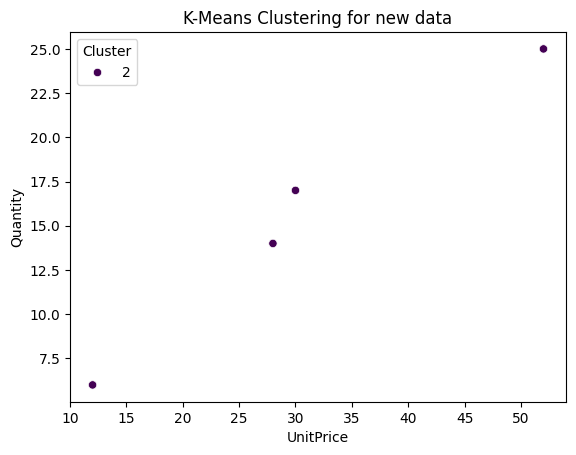

In [90]:
loaded_encoder = joblib.load('../models/label_encoder.joblib')
loaded_kmeans = joblib.load('../models/kmeans_model.joblib')

new_data = pd.DataFrame({
    'Quantity': [14.0, 25, 6, 17],
    'UnitPrice': [28, 52, 12, 30],
    'Country': ['France', 'France', 'United Kingdom', 'France']
})

new_data['TotalPrice'] = new_data['Quantity'] * new_data['UnitPrice']
new_data['Country'] = loaded_encoder.transform(new_data['Country'])

new_clusters = loaded_kmeans.predict(new_data)
new_data['Cluster'] = new_clusters
print(f"Cluster for new data: \n{new_data}")
sns.scatterplot(x='UnitPrice', y='Quantity', hue='Cluster', data=new_data, palette='viridis')
plt.title('K-Means Clustering for new data')
plt.show()

In [93]:
print(new_clusters)

[2 2 2 2]


In [94]:
cluster = loaded_encoder.inverse_transform(new_clusters)